# Confusion matrices

In [1]:
import os
import json 
import torch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [24]:
model_dir = "models/hrf_classifier_20241120-115822"
predictions_filename = os.path.join(model_dir, "predictions.parquet")
predictions = pd.read_parquet(predictions_filename)
predictions

,AGN,Blazar,CEP,CV/Nova,DSCT,EA,EB/EW,LPV,Microlensing,Periodic-Other,...,RSCVn,SLSN,SNII,SNIIb,SNIIn,SNIa,SNIbc,TDE,YSO,shorten
index,,,,,,,,,,,,,,,,,,,,,
aid_ZTF17aaaocpq,0.274019,0.323965,0.008282,0.031802,0.000200,0.001479,0.001386,0.039735,0.005580,0.002421,...,0.004218,0.001649,0.001029,0.000231,0.002013,0.000731,0.000421,0.000936,0.231688,1024
aid_ZTF17aaazbbb,0.629874,0.185243,0.001720,0.015746,0.000444,0.001086,0.000787,0.002478,0.000000,0.001524,...,0.004451,0.000865,0.000776,0.000451,0.001346,0.000563,0.000462,0.000823,0.092441,1024
aid_ZTF17aaazlzl,0.408327,0.172802,0.004067,0.028232,0.001411,0.010718,0.004368,0.006268,0.006507,0.006418,...,0.007182,0.012353,0.022126,0.013199,0.028323,0.028211,0.021079,0.019514,0.157944,1024
aid_ZTF17aaazuft,0.539812,0.193079,0.000763,0.004397,0.000230,0.000342,0.000220,0.003231,0.002192,0.001251,...,0.001155,0.001676,0.002415,0.001360,0.004359,0.003671,0.002460,0.001648,0.145894,1024
aid_ZTF17aabhjci,0.260460,0.237665,0.019066,0.071313,0.000772,0.002793,0.002440,0.009558,0.011998,0.003923,...,0.009729,0.016334,0.020237,0.012147,0.044138,0.026238,0.015662,0.053918,0.119287,1024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
aid_ZTF23aamaycf,0.084641,0.066134,0.013404,0.004160,0.000068,0.002840,0.000685,0.019891,0.007628,0.001633,...,0.007985,0.000499,0.000885,0.000295,0.000910,0.001292,0.000806,0.000524,0.758198,None
aid_ZTF23aaoscaj,0.036648,0.087262,0.045043,0.050203,0.014285,0.050833,0.026705,0.046977,0.126285,0.046988,...,0.055265,0.039126,0.015003,0.004889,0.022219,0.016454,0.007513,0.029824,0.235021,None
aid_ZTF23aappeda,0.013489,0.020425,0.051481,0.083976,0.008262,0.122116,0.059358,0.012554,0.180265,0.026806,...,0.033176,0.013771,0.008689,0.004237,0.012859,0.005574,0.009469,0.012581,0.259119,None


In [25]:
predictions.index.nunique()

41687

In [26]:
time_to_eval = 2048

order_classes = ['SNIa', # yes
                 'SNIbc', # yes
                 'SNIIb', # yes
                 'SNII', # yes
                 'SNIIn', # yes
                 'SLSN', # yes
                 'TDE', # yes
                 'Microlensing', # yes
                 'QSO', 
                 'AGN', # yes
                 'Blazar', 
                 'YSO', 
                 'CV/Nova', 
                 'LPV', 
                 'EA', 
                 'EB/EW', # yes
                 'Periodic-Other', 
                 'RSCVn', 
                 'CEP', 
                 'RRLab', 
                 'RRLc', 
                 'DSCT']

In [27]:
len(order_classes)

22

In [28]:
objects_partitions = pd.read_parquet('../../data_acquisition/ztf_forced_fotometry/partitions/241119/partitions.parquet')
obj_label = objects_partitions[objects_partitions['partition'] == 'test']
y_real_test = obj_label['alerceclass'].values
obj_label = ['aid_{}'.format(x) for x in obj_label['oid'].values]
obj_label

['aid_ZTF18abnukht',
 'aid_ZTF17aabxfzy',
 'aid_ZTF18aazwmdx',
 'aid_ZTF19aclfauc',
 'aid_ZTF18aaodyyn',
 'aid_ZTF17aabgoup',
 'aid_ZTF18aawvlsj',
 'aid_ZTF19abqanpy',
 'aid_ZTF18abbulky',
 'aid_ZTF19acyxuwh',
 'aid_ZTF21achakto',
 'aid_ZTF21acbqhoo',
 'aid_ZTF20aaybvnb',
 'aid_ZTF21aawztrg',
 'aid_ZTF18achdntb',
 'aid_ZTF18aaptcwa',
 'aid_ZTF17aaafieu',
 'aid_ZTF19aassknd',
 'aid_ZTF17aaaeayf',
 'aid_ZTF17aaasjea',
 'aid_ZTF18aabhztc',
 'aid_ZTF21accibae',
 'aid_ZTF19aaaonud',
 'aid_ZTF18achyqcq',
 'aid_ZTF18abnttfy',
 'aid_ZTF21aagkzve',
 'aid_ZTF17aabusvp',
 'aid_ZTF17aaahfho',
 'aid_ZTF18abboazo',
 'aid_ZTF20abegate',
 'aid_ZTF18aclceyr',
 'aid_ZTF18abbwwfs',
 'aid_ZTF18abfzzul',
 'aid_ZTF18aamhoda',
 'aid_ZTF19acbtljt',
 'aid_ZTF19aauojfb',
 'aid_ZTF22abunqtv',
 'aid_ZTF23abavrya',
 'aid_ZTF18aaypawy',
 'aid_ZTF21aaesdgz',
 'aid_ZTF20aaofywo',
 'aid_ZTF23aasrcyv',
 'aid_ZTF20abmljfh',
 'aid_ZTF18aaveqks',
 'aid_ZTF19aazljri',
 'aid_ZTF17aaainmx',
 'aid_ZTF19aaakulz',
 'aid_ZTF19aa

In [29]:
y_real_test.shape

(8328,)

In [30]:
len(obj_label)

8328

In [31]:
mapping_classes = {col: i for i, col in enumerate(predictions.columns)}
mapping_classes_inverted = {v: k for k, v in mapping_classes.items()}
print(mapping_classes_inverted)

{0: 'AGN', 1: 'Blazar', 2: 'CEP', 3: 'CV/Nova', 4: 'DSCT', 5: 'EA', 6: 'EB/EW', 7: 'LPV', 8: 'Microlensing', 9: 'Periodic-Other', 10: 'QSO', 11: 'RRLab', 12: 'RRLc', 13: 'RSCVn', 14: 'SLSN', 15: 'SNII', 16: 'SNIIb', 17: 'SNIIn', 18: 'SNIa', 19: 'SNIbc', 20: 'TDE', 21: 'YSO', 22: 'shorten'}


In [32]:
def sort_dict_by_value(d, reverse=False):
    return dict(sorted(d.items(), key=lambda x: x[1], reverse=reverse))

sort_classes = list(sort_dict_by_value(mapping_classes).keys())
print(sort_classes)

['AGN', 'Blazar', 'CEP', 'CV/Nova', 'DSCT', 'EA', 'EB/EW', 'LPV', 'Microlensing', 'Periodic-Other', 'QSO', 'RRLab', 'RRLc', 'RSCVn', 'SLSN', 'SNII', 'SNIIb', 'SNIIn', 'SNIa', 'SNIbc', 'TDE', 'YSO', 'shorten']


In [33]:
predictions

,AGN,Blazar,CEP,CV/Nova,DSCT,EA,EB/EW,LPV,Microlensing,Periodic-Other,...,RSCVn,SLSN,SNII,SNIIb,SNIIn,SNIa,SNIbc,TDE,YSO,shorten
index,,,,,,,,,,,,,,,,,,,,,
aid_ZTF17aaaocpq,0.274019,0.323965,0.008282,0.031802,0.000200,0.001479,0.001386,0.039735,0.005580,0.002421,...,0.004218,0.001649,0.001029,0.000231,0.002013,0.000731,0.000421,0.000936,0.231688,1024
aid_ZTF17aaazbbb,0.629874,0.185243,0.001720,0.015746,0.000444,0.001086,0.000787,0.002478,0.000000,0.001524,...,0.004451,0.000865,0.000776,0.000451,0.001346,0.000563,0.000462,0.000823,0.092441,1024
aid_ZTF17aaazlzl,0.408327,0.172802,0.004067,0.028232,0.001411,0.010718,0.004368,0.006268,0.006507,0.006418,...,0.007182,0.012353,0.022126,0.013199,0.028323,0.028211,0.021079,0.019514,0.157944,1024
aid_ZTF17aaazuft,0.539812,0.193079,0.000763,0.004397,0.000230,0.000342,0.000220,0.003231,0.002192,0.001251,...,0.001155,0.001676,0.002415,0.001360,0.004359,0.003671,0.002460,0.001648,0.145894,1024
aid_ZTF17aabhjci,0.260460,0.237665,0.019066,0.071313,0.000772,0.002793,0.002440,0.009558,0.011998,0.003923,...,0.009729,0.016334,0.020237,0.012147,0.044138,0.026238,0.015662,0.053918,0.119287,1024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
aid_ZTF23aamaycf,0.084641,0.066134,0.013404,0.004160,0.000068,0.002840,0.000685,0.019891,0.007628,0.001633,...,0.007985,0.000499,0.000885,0.000295,0.000910,0.001292,0.000806,0.000524,0.758198,None
aid_ZTF23aaoscaj,0.036648,0.087262,0.045043,0.050203,0.014285,0.050833,0.026705,0.046977,0.126285,0.046988,...,0.055265,0.039126,0.015003,0.004889,0.022219,0.016454,0.007513,0.029824,0.235021,None
aid_ZTF23aappeda,0.013489,0.020425,0.051481,0.083976,0.008262,0.122116,0.059358,0.012554,0.180265,0.026806,...,0.033176,0.013771,0.008689,0.004237,0.012859,0.005574,0.009469,0.012581,0.259119,None


In [34]:
obj_label

['aid_ZTF18abnukht',
 'aid_ZTF17aabxfzy',
 'aid_ZTF18aazwmdx',
 'aid_ZTF19aclfauc',
 'aid_ZTF18aaodyyn',
 'aid_ZTF17aabgoup',
 'aid_ZTF18aawvlsj',
 'aid_ZTF19abqanpy',
 'aid_ZTF18abbulky',
 'aid_ZTF19acyxuwh',
 'aid_ZTF21achakto',
 'aid_ZTF21acbqhoo',
 'aid_ZTF20aaybvnb',
 'aid_ZTF21aawztrg',
 'aid_ZTF18achdntb',
 'aid_ZTF18aaptcwa',
 'aid_ZTF17aaafieu',
 'aid_ZTF19aassknd',
 'aid_ZTF17aaaeayf',
 'aid_ZTF17aaasjea',
 'aid_ZTF18aabhztc',
 'aid_ZTF21accibae',
 'aid_ZTF19aaaonud',
 'aid_ZTF18achyqcq',
 'aid_ZTF18abnttfy',
 'aid_ZTF21aagkzve',
 'aid_ZTF17aabusvp',
 'aid_ZTF17aaahfho',
 'aid_ZTF18abboazo',
 'aid_ZTF20abegate',
 'aid_ZTF18aclceyr',
 'aid_ZTF18abbwwfs',
 'aid_ZTF18abfzzul',
 'aid_ZTF18aamhoda',
 'aid_ZTF19acbtljt',
 'aid_ZTF19aauojfb',
 'aid_ZTF22abunqtv',
 'aid_ZTF23abavrya',
 'aid_ZTF18aaypawy',
 'aid_ZTF21aaesdgz',
 'aid_ZTF20aaofywo',
 'aid_ZTF23aasrcyv',
 'aid_ZTF20abmljfh',
 'aid_ZTF18aaveqks',
 'aid_ZTF19aazljri',
 'aid_ZTF17aaainmx',
 'aid_ZTF19aaakulz',
 'aid_ZTF19aa

In [35]:
predictions[predictions['shorten'] == 'None']

,AGN,Blazar,CEP,CV/Nova,DSCT,EA,EB/EW,LPV,Microlensing,Periodic-Other,...,RSCVn,SLSN,SNII,SNIIb,SNIIn,SNIa,SNIbc,TDE,YSO,shorten
index,,,,,,,,,,,,,,,,,,,,,
aid_ZTF17aaaocpq,0.274019,0.323965,0.008282,0.031802,0.000200,0.001479,0.001386,0.039735,0.005580,0.002421,...,0.004218,0.001649,0.001029,0.000231,0.002013,0.000731,0.000421,0.000936,0.231688,None
aid_ZTF17aaazbbb,0.545738,0.262871,0.002778,0.013270,0.000605,0.001066,0.000852,0.003420,0.000000,0.001888,...,0.003893,0.001148,0.000738,0.000394,0.001331,0.000527,0.000352,0.000807,0.090415,None
aid_ZTF17aaazlzl,0.408327,0.172802,0.004067,0.028232,0.001411,0.010718,0.004368,0.006268,0.006507,0.006418,...,0.007182,0.012353,0.022126,0.013199,0.028323,0.028211,0.021079,0.019514,0.157944,None
aid_ZTF17aaazuft,0.539812,0.193079,0.000763,0.004397,0.000230,0.000342,0.000220,0.003231,0.002192,0.001251,...,0.001155,0.001676,0.002415,0.001360,0.004359,0.003671,0.002460,0.001648,0.145894,None
aid_ZTF17aabhjci,0.266161,0.261065,0.017276,0.075081,0.000835,0.002395,0.001740,0.010024,0.011233,0.004207,...,0.008311,0.013555,0.016964,0.007551,0.034272,0.021647,0.011502,0.034253,0.133264,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
aid_ZTF23aamaycf,0.084641,0.066134,0.013404,0.004160,0.000068,0.002840,0.000685,0.019891,0.007628,0.001633,...,0.007985,0.000499,0.000885,0.000295,0.000910,0.001292,0.000806,0.000524,0.758198,None
aid_ZTF23aaoscaj,0.036648,0.087262,0.045043,0.050203,0.014285,0.050833,0.026705,0.046977,0.126285,0.046988,...,0.055265,0.039126,0.015003,0.004889,0.022219,0.016454,0.007513,0.029824,0.235021,None
aid_ZTF23aappeda,0.013489,0.020425,0.051481,0.083976,0.008262,0.122116,0.059358,0.012554,0.180265,0.026806,...,0.033176,0.013771,0.008689,0.004237,0.012859,0.005574,0.009469,0.012581,0.259119,None


In [36]:
atat_pred_2048_time_test = predictions[predictions['shorten'] == 'None']
atat_pred_2048_time_test = atat_pred_2048_time_test.reindex(obj_label)[sort_classes]
atat_pred_2048_time_test

,AGN,Blazar,CEP,CV/Nova,DSCT,EA,EB/EW,LPV,Microlensing,Periodic-Other,...,RSCVn,SLSN,SNII,SNIIb,SNIIn,SNIa,SNIbc,TDE,YSO,shorten
index,,,,,,,,,,,,,,,,,,,,,
aid_ZTF18abnukht,0.001725,0.001185,0.038822,0.025608,0.024564,0.688700,0.083110,0.008891,0.000758,0.026607,...,0.039902,0.001164,0.001755,0.000989,0.002040,0.002365,0.001283,0.002959,0.028519,None
aid_ZTF17aabxfzy,0.000892,0.001666,0.008862,0.037268,0.004571,0.001558,0.013720,0.000218,0.001578,0.021416,...,0.008998,0.007581,0.005660,0.001547,0.006492,0.002925,0.002946,0.005346,0.007382,None
aid_ZTF18aazwmdx,0.018508,0.033984,0.047536,0.051402,0.019439,0.144631,0.058621,0.011143,0.175964,0.043574,...,0.061423,0.016867,0.007410,0.004254,0.017537,0.004074,0.004188,0.015846,0.192507,None
aid_ZTF19aclfauc,0.006875,0.006907,0.285207,0.053663,0.092366,0.046204,0.071676,0.048164,0.009544,0.140359,...,0.070453,0.006937,0.005106,0.003066,0.007094,0.006191,0.003640,0.004111,0.043637,None
aid_ZTF18aaodyyn,0.000339,0.001194,0.033158,0.020241,0.017579,0.012119,0.009223,0.001508,0.001664,0.012496,...,0.003859,0.000654,0.000375,0.000122,0.000405,0.000261,0.000218,0.000602,0.002968,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
aid_ZTF18aazemmw,0.008918,0.013335,0.012377,0.012607,0.000014,0.005762,0.002695,0.010696,0.003896,0.001407,...,0.002673,0.001026,0.000544,0.000163,0.000847,0.000381,0.000392,0.000611,0.916537,None
aid_ZTF18aaaeino,0.000123,0.000325,0.033406,0.015012,0.221195,0.019050,0.126266,0.002626,0.000292,0.084780,...,0.012726,0.000056,0.000068,0.000027,0.000078,0.000087,0.000036,0.000106,0.004496,None
aid_ZTF19aaadnhb,0.002397,0.004056,0.042449,0.063926,0.114953,0.307299,0.164237,0.007719,0.002025,0.088632,...,0.058978,0.001578,0.001391,0.001012,0.001915,0.001682,0.001165,0.001520,0.037932,None


In [37]:
atat_pred_2048_time_test

,AGN,Blazar,CEP,CV/Nova,DSCT,EA,EB/EW,LPV,Microlensing,Periodic-Other,...,RSCVn,SLSN,SNII,SNIIb,SNIIn,SNIa,SNIbc,TDE,YSO,shorten
index,,,,,,,,,,,,,,,,,,,,,
aid_ZTF18abnukht,0.001725,0.001185,0.038822,0.025608,0.024564,0.688700,0.083110,0.008891,0.000758,0.026607,...,0.039902,0.001164,0.001755,0.000989,0.002040,0.002365,0.001283,0.002959,0.028519,None
aid_ZTF17aabxfzy,0.000892,0.001666,0.008862,0.037268,0.004571,0.001558,0.013720,0.000218,0.001578,0.021416,...,0.008998,0.007581,0.005660,0.001547,0.006492,0.002925,0.002946,0.005346,0.007382,None
aid_ZTF18aazwmdx,0.018508,0.033984,0.047536,0.051402,0.019439,0.144631,0.058621,0.011143,0.175964,0.043574,...,0.061423,0.016867,0.007410,0.004254,0.017537,0.004074,0.004188,0.015846,0.192507,None
aid_ZTF19aclfauc,0.006875,0.006907,0.285207,0.053663,0.092366,0.046204,0.071676,0.048164,0.009544,0.140359,...,0.070453,0.006937,0.005106,0.003066,0.007094,0.006191,0.003640,0.004111,0.043637,None
aid_ZTF18aaodyyn,0.000339,0.001194,0.033158,0.020241,0.017579,0.012119,0.009223,0.001508,0.001664,0.012496,...,0.003859,0.000654,0.000375,0.000122,0.000405,0.000261,0.000218,0.000602,0.002968,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
aid_ZTF18aazemmw,0.008918,0.013335,0.012377,0.012607,0.000014,0.005762,0.002695,0.010696,0.003896,0.001407,...,0.002673,0.001026,0.000544,0.000163,0.000847,0.000381,0.000392,0.000611,0.916537,None
aid_ZTF18aaaeino,0.000123,0.000325,0.033406,0.015012,0.221195,0.019050,0.126266,0.002626,0.000292,0.084780,...,0.012726,0.000056,0.000068,0.000027,0.000078,0.000087,0.000036,0.000106,0.004496,None
aid_ZTF19aaadnhb,0.002397,0.004056,0.042449,0.063926,0.114953,0.307299,0.164237,0.007719,0.002025,0.088632,...,0.058978,0.001578,0.001391,0.001012,0.001915,0.001682,0.001165,0.001520,0.037932,None


In [38]:
atat_pred_2048_time_test.isnull().sum()

AGN               0
Blazar            0
CEP               0
CV/Nova           0
DSCT              0
EA                0
EB/EW             0
LPV               0
Microlensing      0
Periodic-Other    0
QSO               0
RRLab             0
RRLc              0
RSCVn             0
SLSN              0
SNII              0
SNIIb             0
SNIIn             0
SNIa              0
SNIbc             0
TDE               0
YSO               0
shorten           0
dtype: int64

In [39]:
#nan_rows = atat_pred_2048_time_test[atat_pred_2048_time_test.isna().any(axis=1)]
#nan_indices = nan_rows.index
#print(nan_indices)

In [40]:
#position = obj_label.index(nan_indices[0])
#position

In [41]:
atat_pred_2048_time_test

,AGN,Blazar,CEP,CV/Nova,DSCT,EA,EB/EW,LPV,Microlensing,Periodic-Other,...,RSCVn,SLSN,SNII,SNIIb,SNIIn,SNIa,SNIbc,TDE,YSO,shorten
index,,,,,,,,,,,,,,,,,,,,,
aid_ZTF18abnukht,0.001725,0.001185,0.038822,0.025608,0.024564,0.688700,0.083110,0.008891,0.000758,0.026607,...,0.039902,0.001164,0.001755,0.000989,0.002040,0.002365,0.001283,0.002959,0.028519,None
aid_ZTF17aabxfzy,0.000892,0.001666,0.008862,0.037268,0.004571,0.001558,0.013720,0.000218,0.001578,0.021416,...,0.008998,0.007581,0.005660,0.001547,0.006492,0.002925,0.002946,0.005346,0.007382,None
aid_ZTF18aazwmdx,0.018508,0.033984,0.047536,0.051402,0.019439,0.144631,0.058621,0.011143,0.175964,0.043574,...,0.061423,0.016867,0.007410,0.004254,0.017537,0.004074,0.004188,0.015846,0.192507,None
aid_ZTF19aclfauc,0.006875,0.006907,0.285207,0.053663,0.092366,0.046204,0.071676,0.048164,0.009544,0.140359,...,0.070453,0.006937,0.005106,0.003066,0.007094,0.006191,0.003640,0.004111,0.043637,None
aid_ZTF18aaodyyn,0.000339,0.001194,0.033158,0.020241,0.017579,0.012119,0.009223,0.001508,0.001664,0.012496,...,0.003859,0.000654,0.000375,0.000122,0.000405,0.000261,0.000218,0.000602,0.002968,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
aid_ZTF18aazemmw,0.008918,0.013335,0.012377,0.012607,0.000014,0.005762,0.002695,0.010696,0.003896,0.001407,...,0.002673,0.001026,0.000544,0.000163,0.000847,0.000381,0.000392,0.000611,0.916537,None
aid_ZTF18aaaeino,0.000123,0.000325,0.033406,0.015012,0.221195,0.019050,0.126266,0.002626,0.000292,0.084780,...,0.012726,0.000056,0.000068,0.000027,0.000078,0.000087,0.000036,0.000106,0.004496,None
aid_ZTF19aaadnhb,0.002397,0.004056,0.042449,0.063926,0.114953,0.307299,0.164237,0.007719,0.002025,0.088632,...,0.058978,0.001578,0.001391,0.001012,0.001915,0.001682,0.001165,0.001520,0.037932,None


In [42]:
y_pred_test = atat_pred_2048_time_test.drop(['shorten'], axis=1).idxmax(axis=1).values
#y_pred_test = atat_pred_2048_time_test.idxmax(axis=1).values
y_pred_test

array(['EA', 'RRLc', 'YSO', ..., 'EA', 'AGN', 'YSO'], dtype=object)

In [43]:
#y_real_test = np.delete(y_real_test, position)
#y_real_test

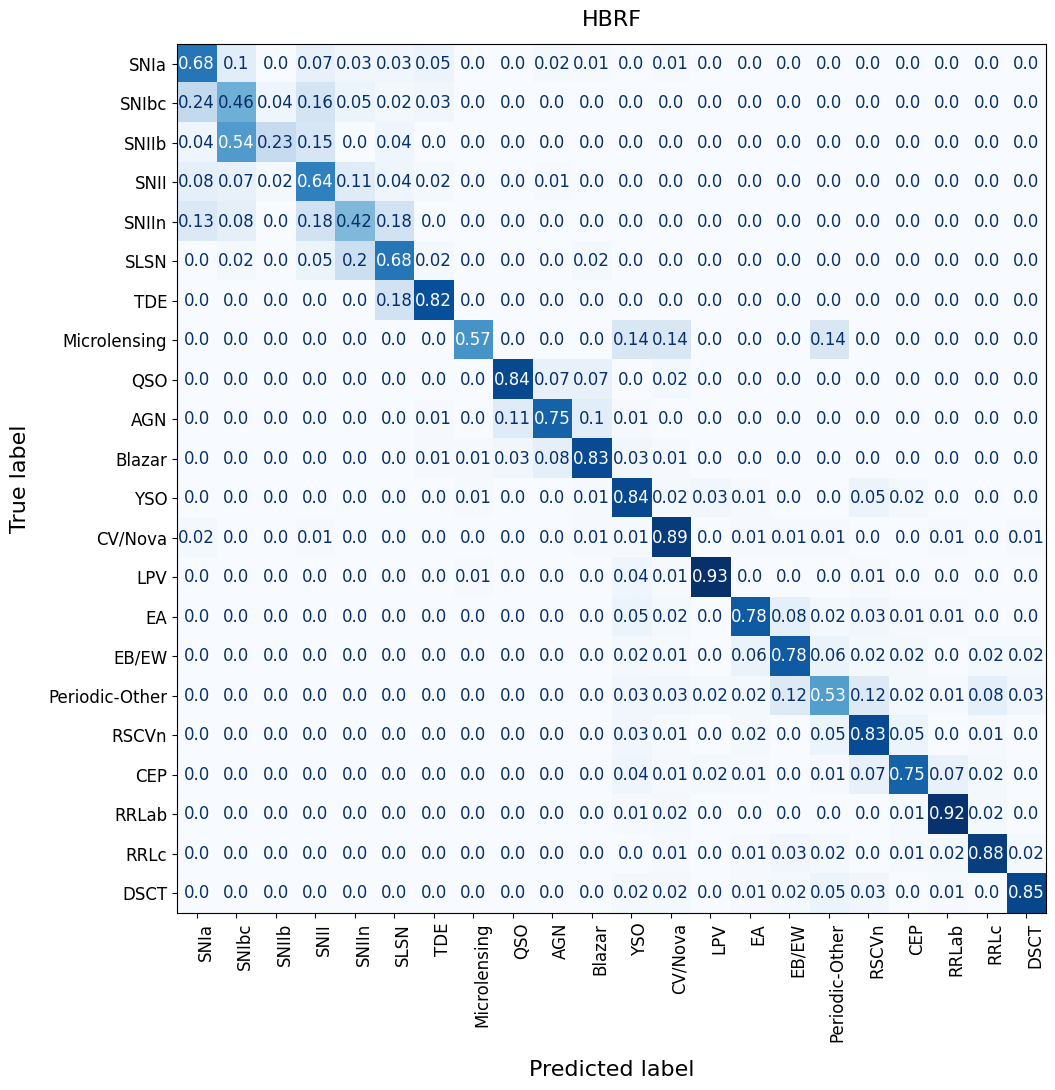

In [44]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

fs = 12

cm = confusion_matrix(y_true=y_real_test, y_pred=y_pred_test, labels=order_classes, normalize='true')

cmap = plt.cm.Blues
fig, ax = plt.subplots(figsize=(11, 11)) #, dpi=110)
im = ax.imshow(np.around(cm, decimals=2), interpolation='nearest', cmap=cmap)

# color map
new_color = cmap(1.0) 

# Añadiendo manualmente las anotaciones con la media y desviación estándar
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if cm[i, j] >= 0.005:
            #print(cm[i, j])
            text = f'{np.around(cm[i, j], decimals=2)}'
            color = "white" if cm[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
            ax.text(j, i, text, ha="center", va="center", color=color, fontsize=fs)
        else:
            text = f'{np.around(cm[i, j], decimals=2)}'
            color = "white" if cm[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
            ax.text(j, i, text, ha="center", va="center", color=color, fontsize=fs)

# Ajustes finales y mostrar la gráfica
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xticks(np.arange(len(order_classes)))
ax.set_yticks(np.arange(len(order_classes)))
ax.set_xticklabels(order_classes)
ax.set_yticklabels(order_classes)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

ax.set_title('HBRF', fontsize=16, pad=13)
ax.set_xlabel('Predicted label', fontsize=16, labelpad=13)  # Label del eje x
ax.set_ylabel('True label', fontsize=16, labelpad=13)        # Label del eje y

ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
ax.xaxis.labelpad = 13
ax.yaxis.labelpad = 13

plt.tight_layout()
plt.show()

In [45]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

f1_score(y_real_test, y_pred_test, average='macro')

0.6783764944030493

In [46]:
class_hierarchy = {
    "transient": [
        "SNIa", 
        "SNIbc", 
        "SNIIb", 
        "SNII", 
        "SNIIn", 
        "SLSN", 
        "TDE"
        ],
    "periodic": [
        "LPV",
        "EA",
        "EB/EW",
        "Periodic-Other",
        "RSCVn",
        "CEP",
        "RRLab",
        "RRLc",
        "DSCT",
    ],
    "stochastic": [
        "QSO",
        "AGN",
        "Blazar",
        "YSO",
        "CV/Nova",
        "Microlensing",  # ulens get confused with stochastic classes
    ],
}

In [47]:
# Generating the classification report.
report = classification_report(y_real_test, y_pred_test, output_dict=True)
report_df = pd.DataFrame(report).T.loc[order_classes + ['macro avg', 'weighted avg']]
report_df['support'] = report_df['support'].astype(int)
report_df[["precision", "recall", "f1-score"]] = report_df[["precision", "recall", "f1-score"]].map(lambda x: round(x, 3))

# Mostrar el reporte actualizado.
report_df

,precision,recall,f1-score,support
SNIa,0.860,0.684,0.762,599
SNIbc,0.323,0.464,0.381,110
SNIIb,0.333,0.231,0.273,26
SNII,0.711,0.645,0.676,321
SNIIn,0.263,0.417,0.323,60
SLSN,0.350,0.683,0.463,41
TDE,0.230,0.824,0.359,17
Microlensing,0.222,0.571,0.320,7
QSO,0.866,0.843,0.854,599
AGN,0.841,0.753,0.795,596


In [48]:
# DataFrame para almacenar el reporte ponderado por clase
weighted_report = pd.DataFrame(columns=["precision", "recall", "f1-score", "support"], index=order_classes)

# Calcular el reporte ponderado por cada clase
for cls in order_classes:
    support_cls = report_df.loc[cls, 'support']
    other_classes = [c for c in order_classes if c != cls]

    # Calcular soporte total de las otras clases
    total_support = report_df.loc[other_classes, 'support'].sum()

    # Calcular métricas ponderadas para cada clase
    weighted_precision = (report_df.loc[other_classes, 'precision'] * report_df.loc[other_classes, 'support']).sum() / total_support
    weighted_recall = (report_df.loc[other_classes, 'recall'] * report_df.loc[other_classes, 'support']).sum() / total_support
    weighted_f1 = (report_df.loc[other_classes, 'f1-score'] * report_df.loc[other_classes, 'support']).sum() / total_support

    # Asignar los valores al DataFrame
    weighted_report.loc[cls] = [round(weighted_precision, 3), round(weighted_recall, 3), round(weighted_f1, 3), support_cls]

# Convertir a tipo int la columna support
weighted_report['support'] = weighted_report['support'].astype(int)
weighted_report

,precision,recall,f1-score,support
SNIa,0.807,0.806,0.804,599
SNIbc,0.817,0.801,0.806,110
SNIIb,0.812,0.799,0.802,26
SNII,0.815,0.803,0.806,321
SNIIn,0.815,0.8,0.804,60
SLSN,0.813,0.798,0.802,41
TDE,0.812,0.797,0.802,17
Microlensing,0.811,0.797,0.801,7
QSO,0.806,0.793,0.797,599
AGN,0.808,0.8,0.801,596


In [49]:
def average_metric(class_group, report, metric):
    values = [report[label][metric] for label in class_group if label in report]
    return np.mean(values)

# Calculating average precision and F1-score for each category
transient_precision = average_metric(class_hierarchy["transient"], report, "precision")
periodic_precision = average_metric(class_hierarchy["periodic"], report, "precision")
stochastic_precision = average_metric(class_hierarchy["stochastic"], report, "precision")

transient_recall = average_metric(class_hierarchy["transient"], report, "recall")
periodic_recall = average_metric(class_hierarchy["periodic"], report, "recall")
stochastic_recall = average_metric(class_hierarchy["stochastic"], report, "recall")

transient_f1 = average_metric(class_hierarchy["transient"], report, "f1-score")
periodic_f1 = average_metric(class_hierarchy["periodic"], report, "f1-score")
stochastic_f1 = average_metric(class_hierarchy["stochastic"], report, "f1-score")

# Creating a DataFrame for the results, matching the order of the classification report (precision, recall, f1-score).
results_df_hier = pd.DataFrame({
    "precision": [
        transient_precision,
        periodic_precision,
        stochastic_precision
    ],
    "recall": [
        transient_recall,
        periodic_recall,
        stochastic_recall
    ],
    "f1-score": [
        transient_f1,
        periodic_f1,
        stochastic_f1
    ]
}, index=["Transient", "Periodic", "Stochastic"])

# Formatting the DataFrame to display three decimal places
results_df_hier = results_df_hier.round(3)

# Updating the DataFrame with the support column.
def total_support(class_group, report):
    supports = [report[label]["support"] for label in class_group if label in report]
    return sum(supports)

transient_support = total_support(class_hierarchy["transient"], report)
periodic_support = total_support(class_hierarchy["periodic"], report)
stochastic_support = total_support(class_hierarchy["stochastic"], report)
results_df_hier["support"] = [transient_support, periodic_support, stochastic_support]
results_df_hier['support'] = results_df_hier['support'].astype(int)
results_df_hier

,precision,recall,f1-score,support
Transient,0.439,0.564,0.462,1174
Periodic,0.826,0.807,0.815,4706
Stochastic,0.693,0.788,0.725,2448


In [50]:
# Function to calculate the weighted average for a given metric based on support.
def weighted_average_metric(class_group, report, metric):
    # Extracting values and their corresponding supports
    values = [report[label][metric] for label in class_group if label in report]
    supports = [report[label]["support"] for label in class_group if label in report]
    # Calculating the weighted average
    weighted_avg = np.average(values, weights=supports)
    return weighted_avg

# Calculating weighted average precision, recall, and F1-score for each category.
transient_precision = weighted_average_metric(class_hierarchy["transient"], report, "precision")
periodic_precision = weighted_average_metric(class_hierarchy["periodic"], report, "precision")
stochastic_precision = weighted_average_metric(class_hierarchy["stochastic"], report, "precision")

transient_recall = weighted_average_metric(class_hierarchy["transient"], report, "recall")
periodic_recall = weighted_average_metric(class_hierarchy["periodic"], report, "recall")
stochastic_recall = weighted_average_metric(class_hierarchy["stochastic"], report, "recall")

transient_f1 = weighted_average_metric(class_hierarchy["transient"], report, "f1-score")
periodic_f1 = weighted_average_metric(class_hierarchy["periodic"], report, "f1-score")
stochastic_f1 = weighted_average_metric(class_hierarchy["stochastic"], report, "f1-score")

# Creating a DataFrame for the results, matching the order of the classification report (precision, recall, f1-score).
results_df_hier = pd.DataFrame({
    "precision": [
        transient_precision,
        periodic_precision,
        stochastic_precision
    ],
    "recall": [
        transient_recall,
        periodic_recall,
        stochastic_recall
    ],
    "f1-score": [
        transient_f1,
        periodic_f1,
        stochastic_f1
    ]
}, index=["Transient", "Periodic", "Stochastic"])

# Formatting the DataFrame to display three decimal places
results_df_hier = results_df_hier.round(3)

# Calculating total support for each category.
transient_support = total_support(class_hierarchy["transient"], report)
periodic_support = total_support(class_hierarchy["periodic"], report)
stochastic_support = total_support(class_hierarchy["stochastic"], report)

# Updating the DataFrame with the support column.
results_df_hier["support"] = [transient_support, periodic_support, stochastic_support]
results_df_hier["support"] = results_df_hier["support"].astype(int)

# Displaying the final DataFrame
results_df_hier

,precision,recall,f1-score,support
Transient,0.700,0.631,0.653,1174
Periodic,0.843,0.824,0.832,4706
Stochastic,0.801,0.825,0.811,2448


In [51]:
from scipy.stats import entropy

In [52]:
plt.hist(entropy(atat_pred_2048_time_test, axis=1), bins=50);
plt.xlabel('entropy')

TypeError: can't multiply sequence by non-int of type 'float'

Text(0.5, 0, 'highest prob')

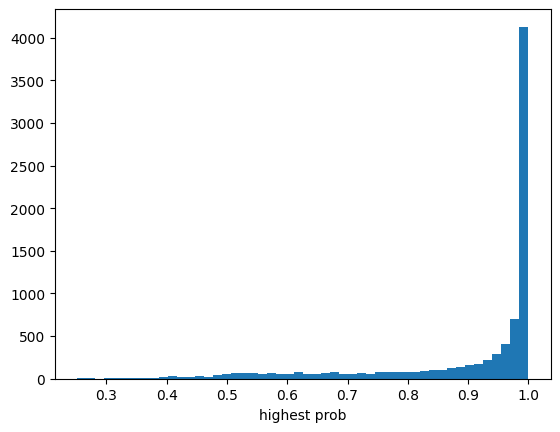

In [40]:
plt.hist(atat_pred_2048_time_test.max(axis=1), bins=50)
plt.xlabel('highest prob')

In [42]:
cm.shape

(22, 22)

In [43]:
# Create a mapping from class names to their indices based on the order in `order_classes`
class_indices = {class_name: idx for idx, class_name in enumerate(order_classes)}
class_indices

{'SNIa': 0,
 'SNIbc': 1,
 'SNIIb': 2,
 'SNII': 3,
 'SNIIn': 4,
 'SLSN': 5,
 'TDE': 6,
 'Microlensing': 7,
 'QSO': 8,
 'AGN': 9,
 'Blazar': 10,
 'YSO': 11,
 'CV/Nova': 12,
 'LPV': 13,
 'EA': 14,
 'EB/EW': 15,
 'Periodic-Other': 16,
 'RSCVn': 17,
 'CEP': 18,
 'RRLab': 19,
 'RRLc': 20,
 'DSCT': 21}

In [44]:
# Initialize the 3x3 matrix for the grouped confusion matrix
conf_matrix_3x3 = np.zeros((3, 3))

# Mapping of group names to matrix indices
group_indices = {'transient': 0, 'periodic': 1, 'stochastic': 2}
group_labels = group_indices.keys()

# Aggregate values into the 3x3 matrix based on `class_hierarchy`
for group_row, classes_row in class_hierarchy.items():
    for group_col, classes_col in class_hierarchy.items():
        row_index = group_indices[group_row]
        col_index = group_indices[group_col]

        # Get indices for current row and column groups
        row_indices = [class_indices[class_name] for class_name in classes_row if class_name in class_indices]
        col_indices = [class_indices[class_name] for class_name in classes_col if class_name in class_indices]

        # Sum values in the specified row and column ranges of the original confusion matrix
        conf_matrix_3x3[row_index, col_index] = cm[np.ix_(row_indices, col_indices)].sum()

# Display the resulting 3x3 confusion matrix
print("Aggregated Confusion Matrix:\n", conf_matrix_3x3)

Aggregated Confusion Matrix:
 [[6.86981327e+00 0.00000000e+00 1.30186733e-01]
 [5.01393069e-03 8.62169505e+00 3.73291024e-01]
 [4.82453697e-01 1.71216570e-01 5.34632973e+00]]


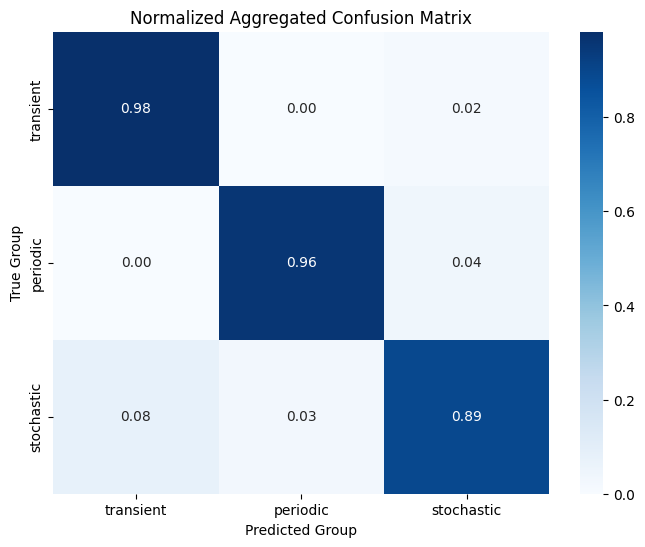

In [45]:
import seaborn as sns

# Normalize the aggregated 3x3 confusion matrix by row (true class)
conf_matrix_3x3_normalized = conf_matrix_3x3 / conf_matrix_3x3.sum(axis=1, keepdims=True)

# Plotting the normalized 3x3 confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_3x3_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=group_labels, yticklabels=group_labels)
plt.title("Normalized Aggregated Confusion Matrix")
plt.xlabel("Predicted Group")
plt.ylabel("True Group")
plt.show()

In [53]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# Map each class name to its group label
group_mapping = {class_name: "transient" for class_name in class_hierarchy["transient"]}
group_mapping.update({class_name: "periodic" for class_name in class_hierarchy["periodic"]})
group_mapping.update({class_name: "stochastic" for class_name in class_hierarchy["stochastic"]})

# Convert y_real_test and y_pred_test to group labels
y_real_group = np.array([group_mapping[label] for label in y_real_test])
y_pred_group = np.array([group_mapping[label] for label in y_pred_test])

# Define group labels for reporting
group_labels = ["transient", "periodic", "stochastic"]

# Calculate macro-averaged metrics for each group
metrics = {}
for group in group_labels:
    # Mask for true positives in the current group
    y_true_binary = (y_real_group == group).astype(int)
    y_pred_binary = (y_pred_group == group).astype(int)
    
    precision = precision_score(y_true_binary, y_pred_binary, zero_division=0)
    recall = recall_score(y_true_binary, y_pred_binary, zero_division=0)
    f1 = f1_score(y_true_binary, y_pred_binary, zero_division=0)
    
    # Storing metrics in the dictionary
    metrics[group] = {
        "precision": round(precision, 3),
        "recall": round(recall, 3),
        "f1-score": round(f1, 3),
        "support": int(np.sum(y_true_binary))
    }

# Creating a DataFrame for the results to match the classification report format
classification_report_df = pd.DataFrame(metrics).T
classification_report_df = classification_report_df[["precision", "recall", "f1-score", "support"]]

# Calculating macro-averaged metrics
macro_precision = np.mean(classification_report_df["precision"])
macro_recall = np.mean(classification_report_df["recall"])
macro_f1 = np.mean(classification_report_df["f1-score"])
macro_support = classification_report_df["support"].sum()

# Adding macro averages to the DataFrame
classification_report_df.loc["macro avg"] = [round(macro_precision, 3), round(macro_recall, 3), round(macro_f1, 3), macro_support]
classification_report_df["support"] = classification_report_df["support"].astype(int)

# Displaying the final classification report-style DataFrame
classification_report_df

,precision,recall,f1-score,support
transient,0.975,0.980,0.977,1174
periodic,0.980,0.958,0.969,4706
stochastic,0.915,0.951,0.933,2448
macro avg,0.957,0.963,0.960,8328


In [54]:
# Recall a partir de la matriz de confusión agregada
recall_transient_matrix = conf_matrix_3x3[0, 0] / conf_matrix_3x3[0, :].sum()

# Recall del reporte de clasificación
recall_transient_report = classification_report_df.loc["stochastic", "recall"]

print(f"Recall (Matriz de Confusión): {recall_transient_matrix:.3f}")
print(f"Recall (Reporte de Clasificación): {recall_transient_report:.3f}")

NameError: name 'conf_matrix_3x3' is not defined

In [55]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import numpy as np
import pandas as pd

# Map each class name to its group label
group_mapping = {class_name: "transient" for class_name in class_hierarchy["transient"]}
group_mapping.update({class_name: "periodic" for class_name in class_hierarchy["periodic"]})
group_mapping.update({class_name: "stochastic" for class_name in class_hierarchy["stochastic"]})

# Convert y_real_test and y_pred_test to group labels
y_real_group = np.array([group_mapping[label] for label in y_real_test])
y_pred_group = np.array([group_mapping[label] for label in y_pred_test])

# Define group labels for reporting
group_labels = ["transient", "periodic", "stochastic"]

# Generate confusion matrix at the group level
group_conf_matrix = confusion_matrix(y_real_group, y_pred_group, labels=group_labels)

# Calculate recall directly from the group-level confusion matrix
recalls = {}
for i, group in enumerate(group_labels):
    tp = group_conf_matrix[i, i]
    fn = group_conf_matrix[i, :].sum() - tp
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    recalls[group] = round(recall, 3)

# Display the results
print("Recall based on group-level confusion matrix:", recalls)

# Optional: Create a DataFrame for a detailed classification report
classification_report_df = pd.DataFrame({
    "recall": [recalls[group] for group in group_labels]
}, index=group_labels)

classification_report_df

Recall based on group-level confusion matrix: {'transient': 0.98, 'periodic': 0.958, 'stochastic': 0.951}


,recall
transient,0.980
periodic,0.958
stochastic,0.951
